In [16]:
import torch
from rff import GaussianRff
from multikernel import MultiKernel

In [17]:
def fun(X):
    N,dim=X.size()
    y=torch.zeros(N)
    for i in range(0,N):
        Xi=torch.cos(X[i,:])*torch.cos(X[i,:])
        y[i]=torch.dot(Xi.t()-1,Xi-1)+1
    return y

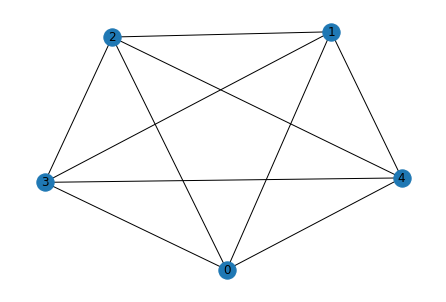

In [18]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import copy

is_communication=True
num_nodes=5
num_init=5
N_per_node=1000
N=int(N_per_node*num_nodes)
dim=1
D=[20,20,20] #number of features
gamma=[0.1,0.5,2]#width of band 
number_kernel=len(D)
num_kernel=3
dim=1
#gamma=1
batch=2
# generate a graph
G=nx.complete_graph (num_nodes)
# G=nx.barabasi_albert_graph (num_nodes,num_init)

rffs=[]
for i in range(0,number_kernel):
    net=torch.nn.Linear(D[i],1,bias=False)
    k=GaussianRff(dim,gamma,net,D[i])
    k.net.weight.data=k.theta.unsqueeze(0)
    rffs.append(k)

for v in range(0,num_nodes):
    rffs_v=copy.deepcopy(rffs)
    multik=MultiKernel(rffs_v)
    G.nodes[v].update({'index':v,'learner':multik})
    G.nodes[v].update({'send_info':[]})  #kernel.theta#send infomation to other nodes
    G.nodes[v].update({'recev_info':[]})
    G.nodes[v].update({'batch':batch})
# graph show
pos = nx.spring_layout(G)
nx.draw(G,pos)
node_labels=nx.get_node_attributes(G,'index')
nx.draw_networkx_labels(G,pos,labels=node_labels)
# distribute data
n_split=np.zeros(num_nodes)+N/num_nodes
for v in range(0,num_nodes):
    x=torch.randn(int(n_split[v]),dim)
    y=fun(x)
    data_split={'x':x,'y':y}
    G.nodes[v].update({'data':data_split})# data -> local nodes 
    # print(G.nodes[i]['data'])
# G.degree(1) number of degree
min_N=int(min(n_split))
T=int(min_N/batch)
plt.savefig('figs/mk/D_N_{}_Mk_G_it_{}_b_{}_D_{}_com_{}.png'.format(num_nodes,int(T),batch,D,is_communication),dpi=600)



In [19]:
import torch.nn.functional as F
# loss=F.mse_loss(yhat, yt)
testN=100
testX=torch.randn(testN,dim)+1
testY=fun(testX)
#########################       MSE         ##################################
T=int(T)
rff_mse_T=torch.zeros(num_nodes,T)#record performance of MK by MSE 
##################################################

# Graph learning

In [20]:
from decentralize_fk_3_0 import GraphLearning
GL=GraphLearning(G)
GL.GLearning(T)

Glearning start!
node 2: train is over!!!!!!!!!

node 3: train is over!!!!!!!!!
node 0: train is over!!!!!!!!!

node 1: train is over!!!!!!!!!
node 4: train is over!!!!!!!!!





In [21]:
##############################################################
mk_mse_T=torch.zeros(num_nodes,int(T))#record performance of MK by MSE
rff_k_mse_T=torch.zeros(num_kernel,num_nodes,int(T))#record performance of simple kernel by MSE   
#########################################################################
for t in range(0,T):
    ####################Evaluation#########################
    for v in range(0,GL.num_nodes):
        for k in range(0,number_kernel):
            weight=GL.graph.nodes[v]['para'][t]['up_para']['weight'][k]
            GL.graph.nodes[v]['learner'].rffs[k].theta=torch.from_numpy(weight).squeeze()
        GL.graph.nodes[v]['learner'].omega=torch.from_numpy(GL.graph.nodes[v]['para'][t]['up_para']['omega'])
        mk_v_ypre_t=GL.graph.nodes[v]['learner'].Fit(testX)
        mk_v_mse_t=F.mse_loss(mk_v_ypre_t,testY)
        mk_mse_T[v,t]=mk_v_mse_t
        for k in range(0,num_kernel):
            rff_k_v_yre_t=GL.graph.nodes[v]['learner'].rffs[k].Fit(testX)
            # print('v{},k{},theta={},X={},y={}'.format(v,i,GL.graph.nodes[v]['learner'].rffs[k].theta[1:3],testX[1:3,:],rff_k_v_yre_t[1:3]))
            rff_k_v_mse_t=F.mse_loss(rff_k_v_yre_t,testY)
            rff_k_mse_T[k,v,t]=rff_k_v_mse_t
# print('loss:{}'.format(mk_mse_T))
# print('kloss:{}'.format(rff_k_mse_T))

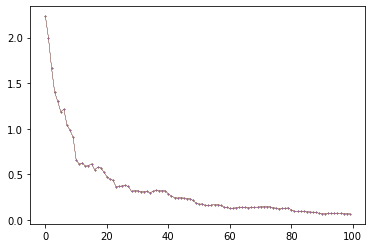

In [22]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
colors=list(mcolors.TABLEAU_COLORS.keys())
plt.figure(0)
for v in range(0,num_nodes):
    # print(v)
    plt.plot(range(0,mk_mse_T.shape[1]),mk_mse_T[v,:],'.-',linewidth=0.2,markersize=1,color=mcolors.TABLEAU_COLORS[colors[v]])
# plt.savefig('figs/mk/D_N_{}_Mk_E_it_{}_b_{}_D_{}_com_{}.png'.format(num_nodes,int(T),batch,D,is_communication),dpi=600)